In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Cargar el archivo depurado.csv
data = pd.read_csv('depurado.csv')

# Convertir la columna de fecha a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Ordenar los datos por fecha
data = data.sort_values('Fecha')

# Seleccionar las columnas de interés
columns_interes = [
    'Diesel bajo azufre',
    'Diesel ultra bajo azufre',
    'Gas licuado de petróleo',
    'Gasolina regular',
    'Gasolina superior',
    'Diesel alto azufre'
]

# Selección de series
series_consumo = data[['Gasolina superior', 'Gasolina regular', 'Diesel bajo azufre', 'Gas licuado de petróleo']]
series_consumo.set_index(data['Fecha'], inplace=True)

# Especificar inicio, fin y frecuencia
for column in series_consumo.columns:
    inicio = series_consumo.index.min()
    fin = series_consumo.index.max()
    frecuencia = pd.infer_freq(series_consumo.index)
    print(f'Consumo de {column} - Inicio: {inicio}, Fin: {fin}, Frecuencia: {frecuencia}')

# Resamplear los datos a un período mensual y sumar los valores para obtener el consumo mensual
monthly_data = data.set_index('Fecha').resample('M').sum()

# Separar los datos en entrenamiento y prueba
train_data, test_data = train_test_split(monthly_data, test_size=0.2, shuffle=False)

# Mostrar las primeras filas del conjunto de entrenamiento
train_data.head()


Consumo de Gasolina superior - Inicio: 2001-01-01 00:00:00, Fin: 2024-05-01 00:00:00, Frecuencia: None
Consumo de Gasolina regular - Inicio: 2001-01-01 00:00:00, Fin: 2024-05-01 00:00:00, Frecuencia: None
Consumo de Diesel bajo azufre - Inicio: 2001-01-01 00:00:00, Fin: 2024-05-01 00:00:00, Frecuencia: None
Consumo de Gas licuado de petróleo - Inicio: 2001-01-01 00:00:00, Fin: 2024-05-01 00:00:00, Frecuencia: None


,Unnamed: 0,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Naftas,Petcoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,MTBE,Orimulsión,Petróleo reconstituido,Total importación
Fecha,,,,,,,,,,,,,,,,,,,,,
2001-01-31,0,0.0,27748.99,214581.84,0.0,0.0,0.0,0.0,194065.738095,820.0,...,0.0,0.0,0.0,0.0,0.0,566101.99,8402.0,0.0,715344.0,2.312639e+06
2001-02-28,1,0.0,7503.57,294609.00,0.0,0.0,0.0,0.0,170703.380952,3054.0,...,0.0,0.0,0.0,0.0,0.0,489525.80,0.0,0.0,370166.0,1.769209e+06
2001-03-31,2,0.0,26304.32,315263.80,0.0,0.0,0.0,0.0,161837.371429,677.0,...,0.0,0.0,0.0,0.0,0.0,575559.68,0.0,0.0,360530.0,1.945770e+06
2001-04-30,3,0.0,7885.89,205653.00,0.0,0.0,0.0,0.0,163048.642857,3399.0,...,0.0,0.0,0.0,0.0,0.0,437745.42,8184.0,0.0,359527.0,1.623638e+06
2001-05-31,4,0.0,8443.16,278371.30,0.0,0.0,0.0,0.0,171518.861905,585.0,...,0.0,0.0,0.0,0.0,0.0,552609.13,12680.0,0.0,723346.0,2.262727e+06


# Paso 2: Crear modelos LSTM

In [3]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(series_consumo)

# Crear secuencias para el LSTM
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, :])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(scaled_data, time_steps)

# Separar en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


2024-08-08 14:07:15.115978: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 14:07:15.118931: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 14:07:15.159363: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 14:07:15.873832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Modelo 1: Configuración básica de LSTM

In [4]:
model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_1.add(Dropout(0.2))
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dropout(0.2))
model_1.add(Dense(y_train.shape[1]))
model_1.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el primer modelo
history_1 = model_1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


2024-08-08 14:07:16.392907: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-08 14:07:16.393370: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/arg/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0605 - val_loss: 0.1145
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0227 - val_loss: 0.0569
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0200 - val_loss: 0.0410
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - val_loss: 0.0213
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0140 - val_loss: 0.0254
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0126 - val_loss: 0.0231
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0116 - val_loss: 0.0239
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0132 - val_loss: 0.0223
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0123 - val_loss: 0.0223
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0132 - val_loss: 0.0211
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136 - val_loss: 0.0212
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0142 - val_loss: 0.0210
Epoch 13/20
7/7 ━━━

# Modelo 2: LSTM con más unidades y más Dropout

In [5]:
model_2 = Sequential()
model_2.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_2.add(Dropout(0.3))
model_2.add(LSTM(100, return_sequences=False))
model_2.add(Dropout(0.3))
model_2.add(Dense(y_train.shape[1]))
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el segundo modelo
history_2 = model_2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0522 - val_loss: 0.0727
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0226 - val_loss: 0.0375
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0164 - val_loss: 0.0298
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0138 - val_loss: 0.0416
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0132 - val_loss: 0.0228
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0127 - val_loss: 0.0202
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0130 - val_loss: 0.0210
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131 - val_loss: 0.0225
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127 - val_loss: 0.0198
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0125 - val_loss: 0.0199
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0120 - val_loss: 0.0212
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - val_loss: 0.0198
E

# Paso 3: Evaluar los modelos y seleccionar el mejor

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


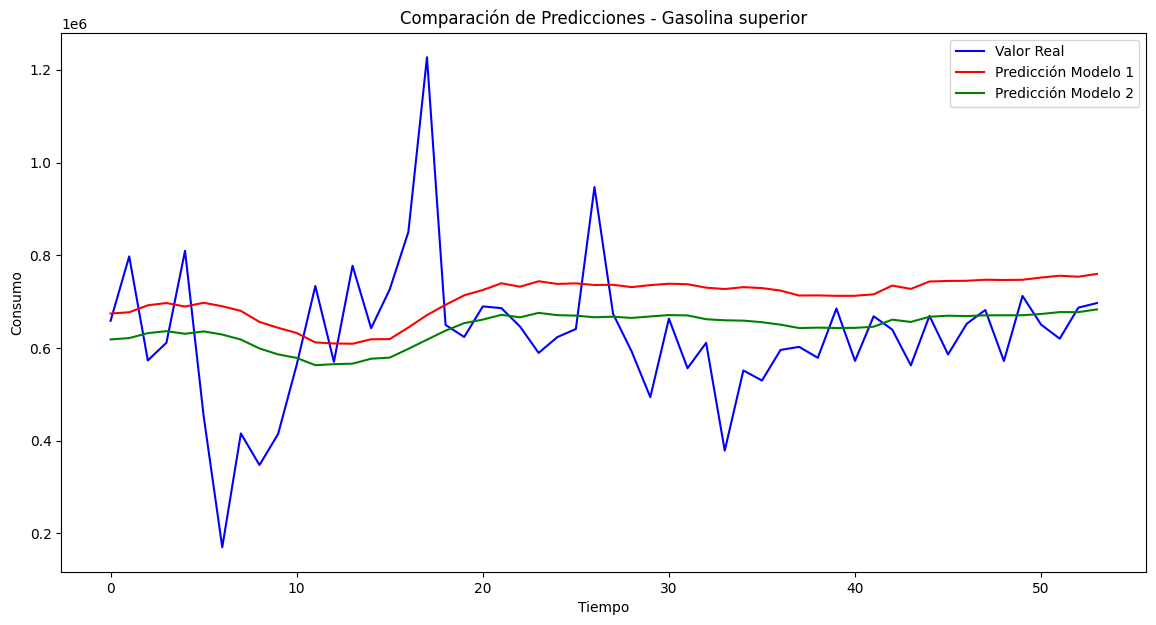

MSE Modelo 1: 27792536141.984177
MSE Modelo 2: 30136460401.237637


In [6]:
import matplotlib.pyplot as plt

# Predecir con ambos modelos
predictions_1 = model_1.predict(X_test)
predictions_2 = model_2.predict(X_test)

# Invertir la escala de las predicciones
predictions_1 = scaler.inverse_transform(predictions_1)
predictions_2 = scaler.inverse_transform(predictions_2)
y_test_inversed = scaler.inverse_transform(y_test)

# Graficar los resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test_inversed[:, 0], color='blue', label='Valor Real')
plt.plot(predictions_1[:, 0], color='red', label='Predicción Modelo 1')
plt.plot(predictions_2[:, 0], color='green', label='Predicción Modelo 2')
plt.title('Comparación de Predicciones - Gasolina superior')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.show()

# Evaluar las métricas de rendimiento
from sklearn.metrics import mean_squared_error

mse_1 = mean_squared_error(y_test_inversed, predictions_1)
mse_2 = mean_squared_error(y_test_inversed, predictions_2)

print(f'MSE Modelo 1: {mse_1}')
print(f'MSE Modelo 2: {mse_2}')
